In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from collections import Counter
import re
from part_of_speech import get_part_of_speech
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans 
import numpy as np
from supervenn import supervenn



This dataset contains text from the profiles of over 59,000 Plenty of Fish users. I want to explore this data to see whether it is possible to divide the users up into clusters whose profiles are similar. I'm not so interested in sex, age, sexual orientation, location or any other type of data that would be somewhat easy to cluster. Instead, I want to focus on the **words** that users employ to describe themselves and their would-be partners. Each user has the opportunity to write 10 essays in their profile, and this is the data that I'm going to explore to ask the following:
- How many clusters do the profiles fall into? Are there several possible 'optimal' cluster numbers?
- Which words are most represented in each of these clusters?
- Are these words shared between clusters or are they unique?
- What do the words say about the individuals writing the profiles?  

First I'll read the file containing the data, clean and normalize the text.

In [24]:
#read csv file containing profile data as DataFrame
df = pd.read_csv('../okcupiddata/profiles.csv')
#make dataframe just containing essays
df_essays = df[['essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7', 'essay8', 'essay9']]
#join all of the columns together into a new column and convert to list
df_essays['corpus'] = df_essays[df_essays.columns[0:]].apply(
    lambda x: ' '.join(x.dropna().astype(str)),
    axis=1)
corpus = df_essays['corpus'].tolist()

#function that removes noise from text
def remove_noise(text):
    '''
    input:
    text- string of text
    output: 
    string of text with html tags, punctuation, newline and tab chars removed
    '''
    #remove html tags
    clean = re.compile('<.*?>')
    text = re.sub(clean, '', text)
    text = re.sub('href', '', text)
    text = re.sub('classilink', '', text)
    text = re.sub('ilink', '', text)
    text = re.sub('&amp', '', text)
    #remove punctuation
    text = re.sub(r"[^\w\d'\s]+",'',text)
    #remove newline, tab
    text = re.sub("(\\d|\\W)+"," ",text)
    return text

#function that lemmatizes text, removes stop words and words <3 characters
def lemmatize(text):
    '''
    input:
    text- string of text
    output:
    lemmatized string of text with stop words and words <3 chars removed
    '''
    #instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))
    #tokenize the string for lemmatization and stop word removal
    tokenized = word_tokenize(str(text))
    lemmatized = [lemmatizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized if not token in stop_words and len(token) >2]
    #re-join the tokenized text so that it can be used for Tfidf
    cleaned = " ".join(lemmatized)
    return cleaned

#remove noise from text and lemmatize
denoised = [remove_noise(str(i)) for i in corpus]
normalized = [lemmatize(i) for i in denoised]


<ipython-input-24-fbc58d6be0db>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_essays['corpus'] = df_essays[df_essays.columns[0:]].apply(


Next I'll employ the TF-IDF algorithm to get a measure of word importance in each profile. Then I'll cluster the TF-IDF results using the K-means algorithm so that profiles with similar word importance metrics are grouped together. 

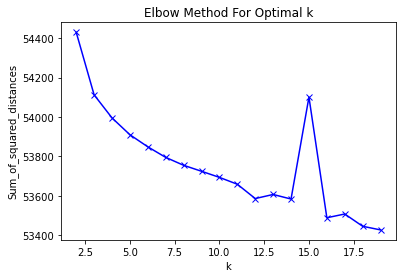

In [26]:
#instatiate Tfidf vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
#fit and transform profile data with vectorizer
tfidf = vectorizer.fit_transform(normalized)

#set up elbow method to determine optimal number of clusters for K-means algorithm
Sum_of_squared_distances = []
#test cluster numbers ranging from 2 to 19
K = range(2,20)

for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10)
   km = km.fit(tfidf)
   Sum_of_squared_distances.append(km.inertia_)

#plot out the sum of squared distances for each K   
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()
#12 could work or 16

It looks like I could select 12 or 16 as optimal numbers of clusters. For the sake of simplicity, I'm going to select 12.

In [82]:

print(type(tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


In [30]:
true_k = 12
#set up clustering
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=true_k)
#fit the data
model.fit(tfidf)

#this loop transforms the numbers back into words
common_words = model.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    #print out the top 10 words in each cluster
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : class, like, love, thing, people, good, time, make, music, think
1 : like, people, thing, good, think, really, love, time, know, make
2 : lol, love, like, friend, know, good, work, time, life, movie
3 : friend, work, fun, like, family, good, look, love, life, guy
4 : love, friend, good, like, music, life, movie, people, family, food
5 : new, friend, love, enjoy, travel, like, good, work, try, time
6 : ask, work, like, want, know, look, eye, love, friend, good
7 : life, love, enjoy, like, good, friend, people, time, make, live
8 : sport, friend, like, love, play, work, family, good, movie, enjoy
9 : music, movie, love, food, book, like, friend, good, work, make
10 : like, love, make, thing, work, music, good, people, time, friend
11 : like, thing, love, good, really, music, make, time, movie, think


In [85]:
#label = model.fit_predict(tfidf)

u_labels = np.unique(label)

tfidf_df = pd.DataFrame(tfidf.todense())

print(tfidf_df.head())
'''
for i in u_labels:
    plt.scatter(tfidf_df[label == i, 0], tfidf_df[label == i, 1], label = i)
plt.legend()
plt.show()
'''

   0       1       2       3       4       5       6       7       8       \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   9       ...  262356  262357  262358  262359  262360  262361  262362  \
0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   262363  262364  262365  
0     0.0     0.0     0.0  
1     0.0     0.0     0.0  
2     0.

'\nfor i in u_labels:\n    plt.scatter(tfidf_df[label == i, 0], tfidf_df[label == i, 1], label = i)\nplt.legend()\nplt.show()\n'

It looks like there is some overlap between the top most important words in each cluster. Now I'll plot a modified venn diagram to visualize this overlap. For orientation: 
- The number of clusters that each group of words is present in is on the top of the diagram. 
- The number of words that I've used to make the diagram is on the right of the diagram. 
- The number of words in the set of words that is between the vertical lines is on the bottom of the diagram.

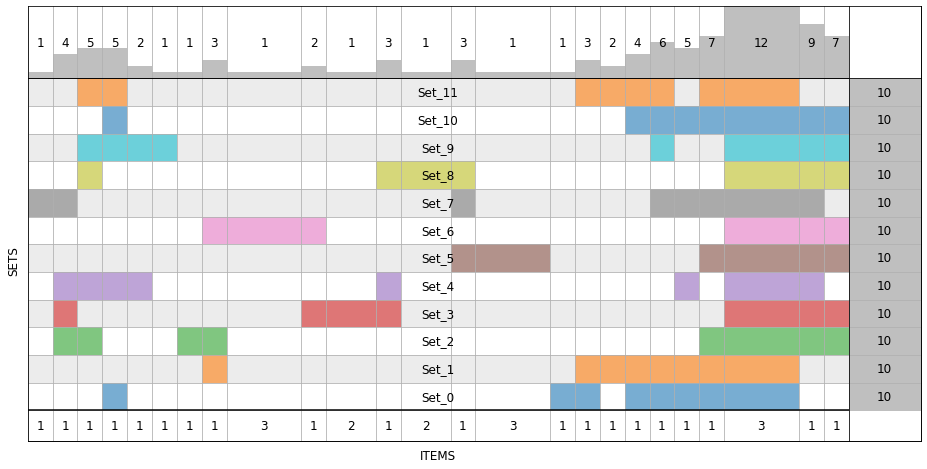

In [31]:
#make a large set of the top ten words from each cluster 
word_list = []
for centroid in common_words:
    word_list.append(set(words[word] for word in centroid))

#plot a modified venn diagram so we can see how the words are shared between clusters
plt.figure(figsize=(16, 8))
supervenn(word_list)

In [67]:
#make a set of all of the words that are in the top 10 lists for each cluster
word_set = []
for cluster in word_list:
    word_set = word_set + list(cluster)

word_set = list(set(word_set))


33


In [68]:
#make a dataframe that indicates whether each of the words in the set are in each cluster
new_list = []
for cluster in word_list:
    lst = []
    for word in word_set:
        if word in cluster:
            lst.append(True)
        else:
            lst.append(False)
    new_list.append(lst)

word_df = pd.DataFrame(new_list, columns = word_set)
word_df


,work,time,lol,make,food,enjoy,class,look,love,really,...,sport,live,guy,people,play,like,thing,ask,life,fun
0,False,True,False,True,False,False,True,False,True,False,...,False,False,False,True,False,True,True,False,False,False
1,False,True,False,True,False,False,False,False,True,True,...,False,False,False,True,False,True,True,False,False,False
2,True,True,True,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,True,False
3,True,False,False,False,False,False,False,True,True,False,...,False,False,True,False,False,True,False,False,True,True
4,False,False,False,False,True,False,False,False,True,False,...,False,False,False,True,False,True,False,False,True,False
5,True,True,False,False,False,True,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
6,True,False,False,False,False,False,False,True,True,False,...,False,False,False,False,False,True,False,True,False,False
7,False,True,False,True,False,True,False,False,True,False,...,False,True,False,True,False,True,False,False,True,False
8,True,False,False,False,False,True,False,False,True,False,...,True,False,False,False,True,True,False,False,False,False
9,True,False,False,True,True,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False


Now I'm going to visualize each word individually in a heat map. Blue squares indicate that a word is present in a cluster.

Text(0.5, 48.453125, 'word')

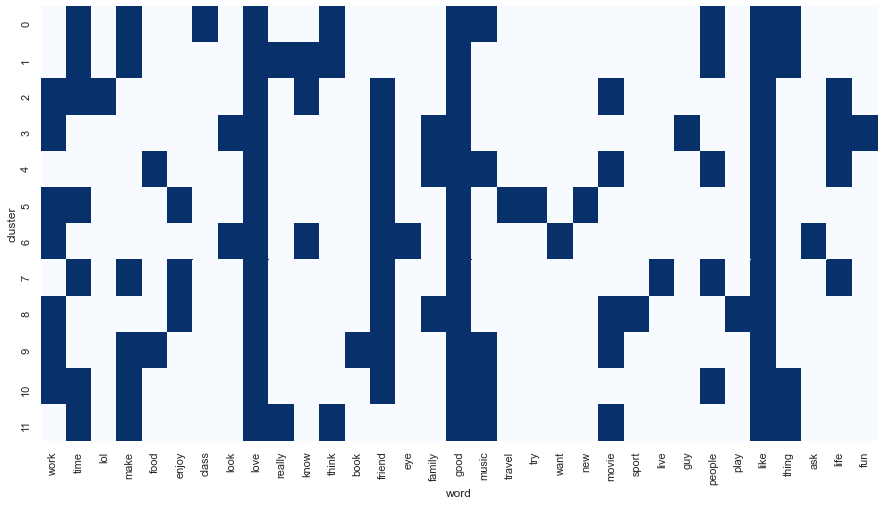

In [76]:
#make a heatmap out of the dataframe so we can visualize which words are common and which words 
#are rare among the clusters
word_df_bin = word_df * 1
sns.set_theme()
dims = (15, 8)
fig, ax = plt.subplots(figsize= dims)
ax = sns.heatmap(word_df_bin, cbar = False, cmap= "Blues")
plt.ylabel("cluster")
plt.xlabel("word")